# Recommendation System from the paper: An Efficient Deep Learning Approach for Collaborative Filtering Recommender System



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, BatchNormalization
from keras.models import Model
from keras import backend as K

In [ ]:
from google.colab import files

print("Please upload your kaggle.json file.")
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [ ]:
! cp ./kaggle.json ~/.kaggle/
! kaggle datasets download -d aprabowo/indonesia-tourism-destination
! unzip indonesia-tourism-destination.zip

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 28.6MB/s]
Archive:  indonesia-tourism-destination.zip
  inflating: package_tourism.csv     
  inflating: tourism_rating.csv      
  inflating: tourism_with_id.csv     
  inflating: user.csv                


In [ ]:
tourism_df = pd.read_csv("./tourism_with_id.csv")
rating_df = pd.read_csv("./tourism_rating.csv")

In [ ]:
tourism_df.tail()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.0,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906,NaN,433
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822,NaN,434
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938,NaN,435
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753,NaN,436
436,437,Gereja Perawan Maria Tak Berdosa Surabaya,Gereja Katolik Kelahiran Santa Perawan Maria m...,Tempat Ibadah,Surabaya,10000,4.8,NaN,"{'lat': -7.2420758, 'lng': 112.7368158}",-7.242076,112.736816,NaN,437


In [ ]:
rating_df.tail()

,User_Id,Place_Id,Place_Ratings
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4
9999,300,163,2


In [ ]:
rating_df.Place_Ratings.unique()

array([3, 2, 5, 4, 1])

In [ ]:
n_tourisms = 437
n_users = 300

print(f"Number of unique tourism places: {n_tourisms}")
print(f"Number of unique users: {n_users}")

Number of unique tourism places: 437
Number of unique users: 300


## Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(rating_df, test_size=0.1, random_state=42)

print(f"Total Training Data: {len(train_df)}")
print(f"Total Testing Data: {len(test_df)}")

Total Training Data: 9000
Total Testing Data: 1000


## Data Modelling

In [ ]:
def make_model(num_neurons_1, activation_type):
  # creating Tourism embedding path
  tourism_input = Input(shape=[1], name="Tourism-Input")
  tourism_embedding = Embedding(n_tourisms + 1, 5, name="Tourism-Embedding")(tourism_input)
  tourism_vec = Flatten(name="Flatten-Tourism")(tourism_embedding)

  # creating user embedding path
  user_input = Input(shape=[1], name="User-Input")
  user_embedding = Embedding(n_users + 1, 5, name="User-Embedding_Tourism_input")(user_input)
  user_vec = Flatten(name="Flatten-Users_Tourism_embedding")(user_embedding)

  # concatenate features
  conc = Concatenate()([tourism_vec, user_vec])

  # add fully-connected-layers
  fc1 = Dense(num_neurons_1, activation=f'{activation_type}')(conc)
  fc1 = BatchNormalization()(fc1)
  fc2 = Dense(num_neurons_1, activation=f'{activation_type}')(fc1)
  fc2 = BatchNormalization()(fc2)
  fc3 = Dense(num_neurons_1, activation=f'{activation_type}')(fc2)
  fc3 = BatchNormalization()(fc3)
  out = Dense(10, activation = "softmax")(fc3)
  out = Dense(1, activation = f"{activation_type}")(out)

  # Create model and compile it
  model = Model([user_input, tourism_input], out)
  model.compile('sgd',  "mean_absolute_error", metrics = [
      tf.keras.metrics.RootMeanSquaredError(),
  ])
  return model

In [ ]:
result_df = pd.DataFrame(
    columns = ["Neurons", "Activation", "RMSE", "MAE"]
)

class ReportCallback(tf.keras.callbacks.Callback):
  def __init__(self, neurons, activation):
    super(ReportCallback, self).__init__()
    self.neurons = neurons
    self.activation = activation
  def on_train_end(self, logs=None):
    global result_df
    print(f'Train RMSE: {logs["root_mean_squared_error"]}')
    print(f'Train MAE: {logs["loss"]}')
    print(f'Test RMSE: {logs["val_root_mean_squared_error"]}')
    print(f'Test MAE: {logs["val_loss"]}')

    result_df_new = pd.DataFrame(
      {
        "Neurons": self.neurons,
        "Activation": self.activation,
        "RMSE": [logs["val_root_mean_squared_error"]],
        "MAE": [logs["val_loss"]],
      }
    )
    result_df_2 = result_df.append(result_df_new, ignore_index = True)
    result_df = result_df_2

num_neurons_1 = [32, 64, 128]
activation_types = ["relu", "elu", "selu"]

for num_neuron in num_neurons_1:
  for activation_type in activation_types:
    report_callback = ReportCallback(num_neuron, activation_type)

    model = make_model(num_neuron, activation_type)
    print(f"NUmber of neurons: {num_neuron}, activation type: {activation_type}")
    history = model.fit(
        [train_df.User_Id, train_df.Place_Id],
        train_df.Place_Ratings,
        validation_data = ([test_df.User_Id, test_df.Place_Id], test_df.Place_Ratings),
        epochs = 30,
        batch_size = 64,
        verbose = 0,
        callbacks = [report_callback]
    )

NUmber of neurons: 32, activation type: relu
Train RMSE: 1.2605805397033691
Train MAE: 1.0355066061019897
Test RMSE: 1.4580702781677246
Test MAE: 1.2309913635253906


<ipython-input-12-bc35e122e4e4>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


NUmber of neurons: 32, activation type: elu
Train RMSE: 1.2717536687850952
Train MAE: 1.0021785497665405
Test RMSE: 1.511716365814209
Test MAE: 1.2450776100158691
NUmber of neurons: 32, activation type: selu


<ipython-input-12-bc35e122e4e4>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


Train RMSE: 1.3114632368087769
Train MAE: 1.0884677171707153
Test RMSE: 1.4381183385849
Test MAE: 1.208886981010437
NUmber of neurons: 64, activation type: relu


<ipython-input-12-bc35e122e4e4>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


Train RMSE: 1.2682902812957764
Train MAE: 1.049689769744873
Test RMSE: 1.445158839225769
Test MAE: 1.2110470533370972
NUmber of neurons: 64, activation type: elu


<ipython-input-12-bc35e122e4e4>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


Train RMSE: 1.3400434255599976
Train MAE: 1.104640007019043
Test RMSE: 1.3863691091537476
Test MAE: 1.1479419469833374
NUmber of neurons: 64, activation type: selu


<ipython-input-12-bc35e122e4e4>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


Train RMSE: 1.3427940607070923
Train MAE: 1.1116266250610352
Test RMSE: 1.4304851293563843
Test MAE: 1.1900136470794678


<ipython-input-12-bc35e122e4e4>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


NUmber of neurons: 128, activation type: relu
Train RMSE: 1.2150392532348633
Train MAE: 0.96439528465271
Test RMSE: 1.4755841493606567
Test MAE: 1.2305710315704346


<ipython-input-12-bc35e122e4e4>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


NUmber of neurons: 128, activation type: elu
Train RMSE: 1.3010269403457642
Train MAE: 1.066089391708374
Test RMSE: 1.4183382987976074
Test MAE: 1.1997517347335815
NUmber of neurons: 128, activation type: selu


<ipython-input-12-bc35e122e4e4>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


Train RMSE: 1.3407058715820312
Train MAE: 1.0977407693862915
Test RMSE: 1.3958295583724976
Test MAE: 1.1648346185684204


<ipython-input-12-bc35e122e4e4>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


In [ ]:
print(result_df)
result_df.to_csv("scalable_deep_learning_result.csv", sep = ";", decimal = ",", index = False)

  Neurons Activation      RMSE       MAE
0      32       relu  1.458070  1.230991
1      32        elu  1.511716  1.245078
2      32       selu  1.438118  1.208887
3      64       relu  1.445159  1.211047
4      64        elu  1.386369  1.147942
5      64       selu  1.430485  1.190014
6     128       relu  1.475584  1.230571
7     128        elu  1.418338  1.199752
8     128       selu  1.395830  1.164835


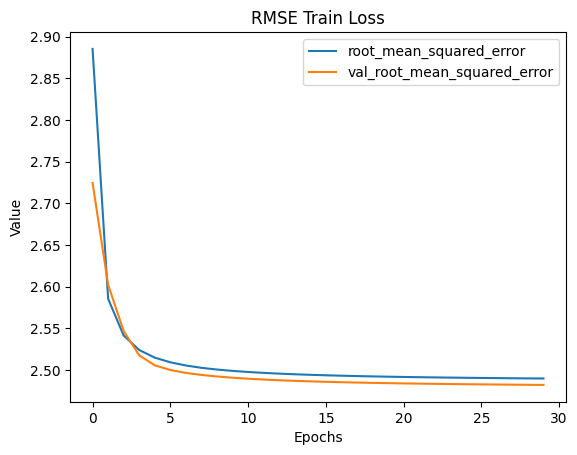

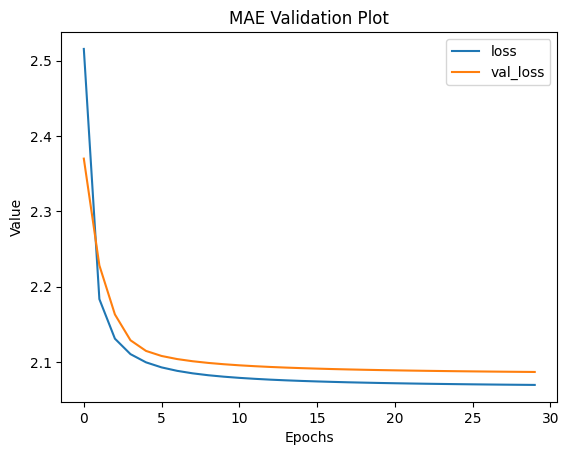

In [ ]:
def plot_data(metric1, metric2, title):
  plt.plot(history.history[metric1])
  plt.plot(history.history[metric2])
  plt.title(title)
  plt.ylabel("Value")
  plt.xlabel("Epochs")
  plt.legend([metric1, metric2], loc="upper right")
  plt.show()

metrics = [["root_mean_squared_error", "val_root_mean_squared_error", "RMSE Train Loss"], ["loss", "val_loss", "MAE Validation Plot"]]

for [metric1, metric2, title] in metrics:
  plot_data(metric1, metric2, title)

In [ ]:
id_place = range(1,20)

# Creating dataset for making recommendations for the first user
tourism_data = np.array(list(set(tourism_df.Place_Id)))
tourism_data[:10]

id_user = 1
user = np.array([id_user for i in range(len(tourism_data))])
user[:10]

predictions = model.predict([user, tourism_data])

predictions = np.array([a[0] for a in predictions])

recommended_tourism_ids = (-predictions).argsort()[:10]

recommended_tourism_ids

14/14 [==============================] - 0s 4ms/step


array([373, 211,  16, 275, 212, 361,  12, 158, 413, 327])

In [ ]:
tourism_df[tourism_df["Place_Id"].isin(recommended_tourism_ids)]

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
11,12,Pulau Pari,Pulau Pari adalah sebuah pulau yang terletak d...,Bahari,Jakarta,150000,4.0,NaN,"{'lat': -5.9074328, 'lng': 106.5863989}",-5.907433,106.586399,NaN,12
15,16,Jembatan Kota Intan,Jembatan Kota Intan adalah jembatan tertua di ...,Budaya,Jakarta,0,4.3,NaN,"{'lat': -6.1314572, 'lng': 106.8106169}",-6.131457,106.810617,NaN,16
157,158,Pantai Pok Tunggal,"Pantai Pok Tunggal atau biasa disebut ""the hid...",Bahari,Yogyakarta,10000,4.5,NaN,"{'lat': -8.1554468, 'lng': 110.6217582}",-8.155447,110.621758,NaN,158
210,211,GunungTangkuban perahu,Gunung Tangkuban Parahu adalah salah satu gunu...,Cagar Alam,Bandung,30000,4.5,NaN,"{'lat': -6.759637700000001, 'lng': 107.6097807}",-6.759638,107.609781,NaN,211
211,212,Jalan Braga,Jalan Braga adalah nama sebuah jalan utama di ...,Budaya,Bandung,0,4.7,NaN,"{'lat': -6.9150534, 'lng': 107.6089842}",-6.915053,107.608984,NaN,212
274,275,Curug Cipanas,Siapa bilang berendam air panas harus merogoh ...,Cagar Alam,Bandung,20000,3.9,180.0,"{'lat': -6.7991958, 'lng': 107.5922088}",-6.799196,107.592209,NaN,275
326,327,Taman Miniatur Kereta Api,Salah satu wisata yang ramai di Bandung adalah...,Taman Hiburan,Bandung,15000,4.4,NaN,"{'lat': -6.817327, 'lng': 107.61794}",-6.817327,107.617940,NaN,327
360,361,Wisata Kampung Krisan Clapar,Wisata Kampung Krisan Gemah Ripah di Dusun Cla...,Taman Hiburan,Semarang,10000,4.1,NaN,"{'lat': -7.214158199999999, 'lng': 110.3769541}",-7.214158,110.376954,NaN,361
372,373,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,Semarang,10000,4.5,60.0,"{'lat': -7.264598899999997, 'lng': 110.4046017}",-7.264599,110.404602,NaN,373
412,413,Museum TNI AL Loka Jala Crana,Museum Loka Jala Crana berdiri pada tanggal 19...,Budaya,Surabaya,2000,4.5,NaN,"{'lat': -7.227185, 'lng': 112.718997}",-7.227185,112.718997,NaN,413
